In [17]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
pip install quandl

In [8]:
import quandl

In [36]:
ethusd = quandl.get("BITFINEX/ETHUSD", authtoken="Jy-C4ogjQjicmLjayJuA")

In [37]:
btcusd = quandl.get("BITFINEX/BTCUSD", authtoken="Jy-C4ogjQjicmLjayJuA")

In [40]:
btceth = pd.merge(btcusd, ethusd, left_on = 'Date', right_on = 'Date', how = 'inner')

In [44]:
btceth = btceth.loc[:,['Last_x','Last_y']].rename(columns = {'Last_x':'BTC_last','Last_y':'ETH_last'})

In [48]:
btc = btceth.BTC_last.values.astype(float)
eth = btceth.ETH_last.values.astype(float)

btc = (btc - btc.mean())/btc.std()
eth = (eth - eth.mean())/eth.std()

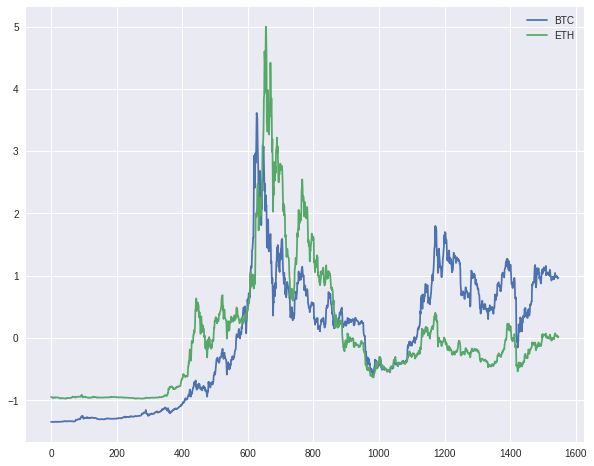

In [50]:
plt.subplots(figsize = (10,8))

plt.plot(btc)
plt.plot(eth)
plt.legend(['BTC','ETH'])
plt.show()

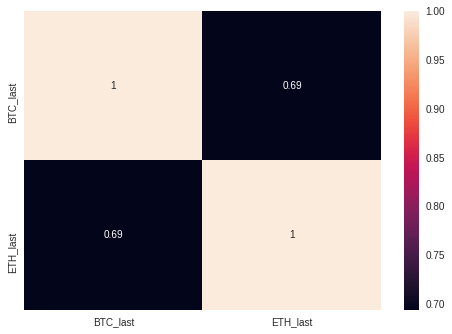

In [302]:
import seaborn as sn

sn.heatmap(btceth.corr(), annot = True)

In [195]:
def univariate_data(dataset, start, end, history_size, target_size):

  n_features = dataset.shape[1]

  data = []
  labels = []

  if not end:
    end = len(dataset)-target_size
  else:
    end = end - target_size
  
  start = start + history_size

  for i in range(start, end):
    data.append(np.array(dataset[i-history_size:i]).reshape(history_size, n_features))
    labels.append(dataset[i:i+target_size,1])

  labels = np.array(labels)
  labels = labels.reshape(labels.shape[0],)

  return np.array(data), labels

In [284]:
data_arr = btceth.values.astype(float)

In [198]:
TRAIN_SIZE = int(len(btceth)*0.95)

In [286]:
btc_mean = data_arr[:TRAIN_SIZE,0].mean()
btc_std = data_arr[:TRAIN_SIZE,0].std()

eth_mean = data_arr[:TRAIN_SIZE,1].mean()
eth_std = data_arr[:TRAIN_SIZE,1].std()

In [292]:
data_arr[:,0] = (data_arr[:,0] - btc_mean)/btc_std
data_arr[:,1] = (data_arr[:,1] - eth_mean)/eth_std

In [293]:
X_train, y_train = univariate_data(data_arr, 0, TRAIN_SIZE, 14, 1)
X_test, y_test = univariate_data(data_arr, TRAIN_SIZE, len(btceth),14, 1)

In [294]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(100).batch(20).repeat()

val_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test))
val_dataset = val_dataset.batch(20).repeat()

In [295]:
lstm_model = tf.keras.Sequential([tf.keras.layers.LSTM(units = 14, input_shape = X_train.shape[1:]),
                                  tf.keras.layers.Dense(1)])

In [296]:
lstm_model.compile(optimizer='adam', loss = 'mse')

In [297]:
history = lstm_model.fit(train_dataset, epochs = 10, steps_per_epoch=1000, validation_data=val_dataset, validation_steps=50)

Epoch 1/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0806 - val_loss: 0.0018
Epoch 2/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0131 - val_loss: 0.0010
Epoch 3/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0111 - val_loss: 8.4460e-04
Epoch 4/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0100 - val_loss: 7.5952e-04
Epoch 5/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0091 - val_loss: 0.0028
Epoch 6/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0083 - val_loss: 6.9532e-04
Epoch 7/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0086 - val_loss: 0.0013
Epoch 8/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0083 - val_loss: 0.0011
Epoch 9/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0074 - val_loss: 7.2705e-04
Epoch 10/10
1000/1000 [==============================] - 6s 6ms/st

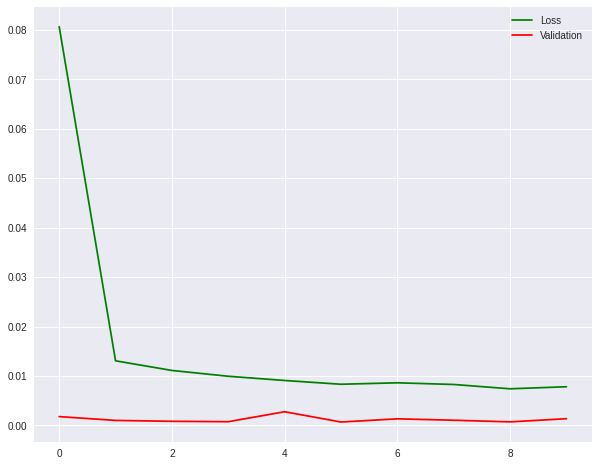

In [299]:
plt.subplots(figsize = (10,8))

plt.plot(history.history['loss'], color = 'green')
plt.plot(history.history['val_loss'], color = 'red')

plt.legend(['Loss','Validation'])
plt.show()

In [244]:
def timesteps(x):
  return range(-len(x),0)

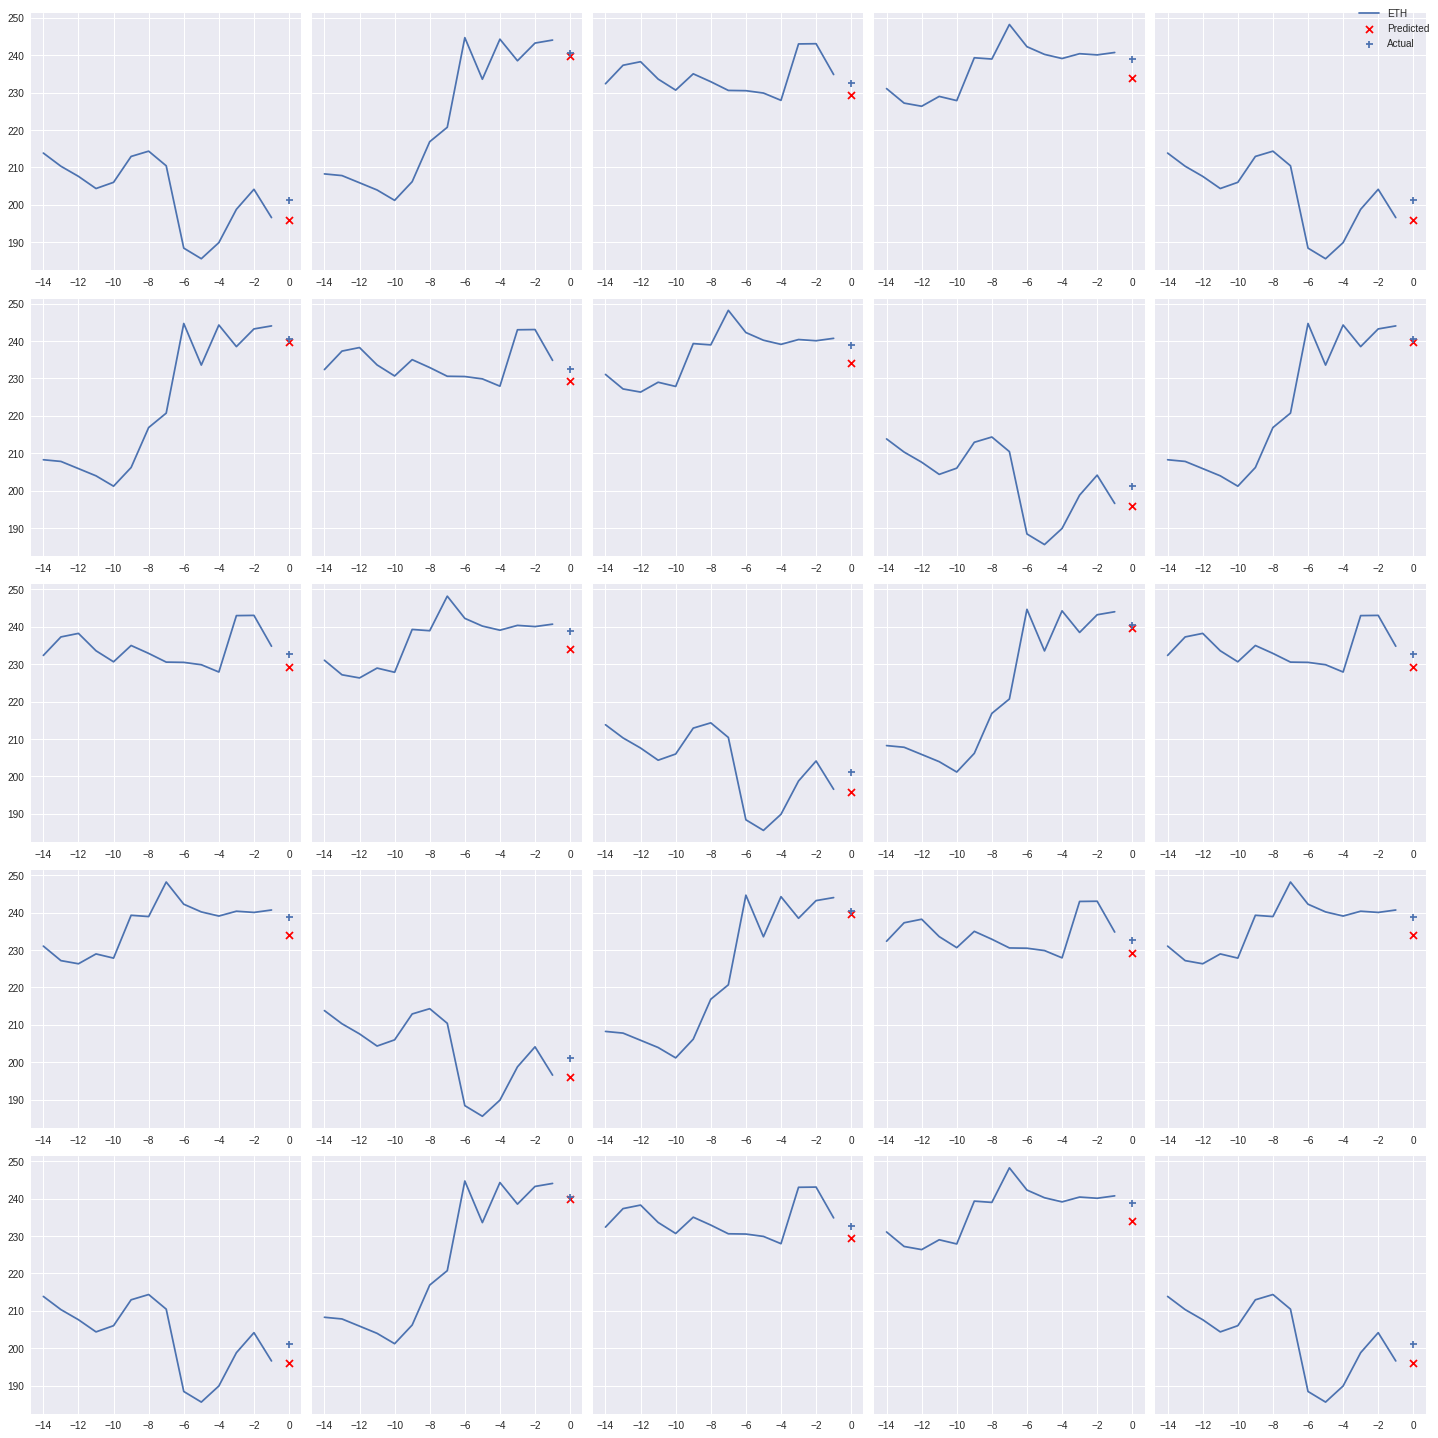

In [301]:
fig,ax = plt.subplots(5, 5, figsize = (20,20), sharey = True)

for i, (x, y) in enumerate(val_dataset.take(25)):
  r = int(i/5)
  c = i % 5

  ax[r][c].plot(timesteps(x[0]),x[0].numpy()[:,1]*eth_std+eth_mean)
  ax[r][c].scatter(0, lstm_model.predict(x)[0]*eth_std+eth_mean, marker = 'x', color = 'red')
  ax[r][c].scatter(0,y.numpy()[0]*eth_std+eth_mean, marker = '+')

fig.legend(['ETH','Predicted','Actual'])
plt.tight_layout()
plt.show()

Lets try and predict ETH price for tomrrow (20 July)

In [312]:
july_20_price = btceth.iloc[-14:,:].values.astype(float)
july_20_price[:,0] = (july_20_price[:,0] - btc_mean) / btc_std
july_20_price[:,1] = (july_20_price[:,1] - eth_mean) / eth_std

In [314]:
lstm_model.predict(np.array([july_20_price]))[0][0]*eth_std + eth_mean

228.33754312175608